# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [10]:
import pyarrow
import logging
import sys
from matplotlib_venn import venn3
from pandas.tseries.offsets import MonthEnd
from pandas import DataFrame
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
import scipy
from surprise import Dataset, Reader, SVD, accuracy, NormalPredictor
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool
from contextlib import asynccontextmanager
from fastapi import FastAPI
from contextlib import asynccontextmanager
import requests

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- category_tree.csv — таблица из двух столбцов: «родительская категория» и «дочерняя категория». Типичный способ представления таблицы в виде дерева.
- events.csv — таблица с логом событий
- - timestamp — временная метка события,
- - visitorid — идентификатор пользователя,
- - event — событие (просмотр, добавление в корзину, покупка),
- - itemid — идентификатор товара,
- - transactionid — идентификатор транзакции (покупки).
- item_properties.csv — таблица со свойствами товаров:
- - timestamp — временная метка добавления свойства,
- - itemid — идентификатор товара,
- - property — свойство товара,
- - value — значение свойства.

In [60]:
items_1 = pd.read_csv("./data/e-comerce/item_properties_part1.csv")
items_2 = pd.read_csv("./data/e-comerce/item_properties_part2.csv")
events = pd.read_csv("./data/e-comerce/events.csv")
category = pd.read_csv("./data/e-comerce/category_tree.csv")

In [36]:
print("Данные загружены")
print("items 1:", items_1.shape, "items 2:", items_2.shape, "category:", category.shape, "events:", events.shape)

Данные загружены
items 1: (10999999, 4) items 2: (9275903, 4) category: (1669, 2) events: (2756101, 5)


In [14]:
items_1.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [15]:
items_2.head()

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062


In [16]:
category.head(5)

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [37]:
items = pd.concat([items_1, items_2])
items.shape

(20275902, 4)

In [38]:
items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


In [61]:
events.head(10)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
5,1433224086234,972639,view,22556,NaN
6,1433221923240,810725,view,443030,NaN
7,1433223291897,794181,view,439202,NaN
8,1433220899221,824915,view,428805,NaN
9,1433221204592,339335,view,82389,NaN


In [40]:
events["event"].unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

In [41]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [42]:
items.head(5)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

#### 1. Проверка общей целостности данных
- Количество строк и дубликаты:

In [95]:
print("Уникальных itemid:", items['itemid'].nunique(), "из", len(items))
print("Уникальных catalog_ids:", category['categoryid'].nunique(), "из", len(category))
print("Уникальных events:", events.drop_duplicates().shape[0], "из", len(events))

Уникальных itemid: 417053 из 20275902
Уникальных catalog_ids: 1669 из 1669
Уникальных events: 2755641 из 2756101


In [ ]:
# преобразование нужно перенести в обработку данных в airflow
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')

In [63]:
events.head(5)

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


In [70]:
# преобразование нужно перенести в обработку данных в airflow
items['timestamp'] = pd.to_datetime(items['timestamp'], unit='ms')

In [71]:
items.head(5)

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513


In [65]:
category.head(5)

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [67]:
# проверим category на дубликаты
print("Уникальных categoryid:", category.drop_duplicates(['categoryid', 'parentid'], keep='first').shape[0], "из", len(category))

Уникальных categoryid: 1669 из 1669


In [69]:
print("Уникальных categoryid:", category.drop_duplicates(['parentid'], keep='first').shape[0], "из", len(category))

Уникальных categoryid: 363 из 1669


In [75]:
# Проверка пропусков 
print('=== items:\n', items.isna().sum())
print('=== category:\n',category.isna().sum())
print('=== events:\n', events.isna().sum())

=== items:
 timestamp    0
itemid       0
property     0
value        0
dtype: int64
=== category:
 categoryid     0
parentid      25
dtype: int64
=== events:
 timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64


- **items** - нет пропусков
- **category** - пропуски в *parentid* -> видимо 25 элементов без вложенности
- **events** - пропуски в *transactionid* -> нужно проверить при каких значениях остальных полей NaN

In [81]:
events[events.transactionid.notnull()]['event'].unique()

array(['transaction'], dtype=object)

- **events** - столбец *transactionid* не NaN при типе события *event* 'просмотр' и 'добавление в корзину', что логично

#### 2. Проверка связей между таблицами

In [92]:
missing_items = set(events['itemid']) - set(items['itemid'])
print("Нет в items:", len(missing_items), "itemid")

Нет в items: 49815 itemid


если > 0, значит есть 'действия' с продуктами, которых нет в сатегориях

#### 3. Проверка временной логики

In [96]:
# Проверка сортировки по датам
bad_time = (
    events
    .sort_values(["visitorid", "timestamp"])
    .groupby("visitorid")["timestamp"]
    .diff().dt.days < 0
).sum()
print("Нарушений хронологии дат:", bad_time)

Нарушений хронологии дат: 0


отрицательная разница означала бы, что порядок дат нарушен.

#### 4. Логические проверки

In [ ]:
no_item = (events["itemid"] == 0).sum()
no_visitor = (events["visitorid"] == 0).sum()
no_event = (events["event"].apply(len) == 0).sum()

print("события без товаров:", no_item)
print("события без посетителей:", no_visitor)
print("события без событий:", no_event)

события без товаров: 0
события без посетителей: 3
события без событий: 0


In [101]:
events.query('visitorid == 0')

,timestamp,visitorid,event,itemid,transactionid
1361687,2015-09-11 20:49:49.439,0,view,285930,NaN
1367212,2015-09-11 20:52:39.591,0,view,357564,NaN
1367342,2015-09-11 20:55:17.175,0,view,67045,NaN


- видимо это посетитель с id = 0

In [110]:
events['visitorid'].sort_values(ascending=True)

1361687          0
1367212          0
1367342          0
830385           1
737615           2
            ...   
206556     1407575
47311      1407576
1762583    1407577
1744277    1407578
482559     1407579
Name: visitorid, Length: 2756101, dtype: int64

In [112]:
category.head(3)

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0


In [113]:
# Проверим дубли по (categoryid, parentid)
duplicates = category.duplicated(subset=["categoryid","parentid"]).sum()
print(f"Количество полных дублей (categoryid, parentid): {duplicates}")

Количество полных дублей (categoryid, parentid): 0


In [116]:
# Проверим случаи, когда один и тот же categoryid встречается с разными parentid
category_id_counts = category.groupby("categoryid")["parentid"].nunique()
duplicate_names = category_id_counts[category_id_counts > 1].index

print(f"Количество categoryid с разными parentid: {len(duplicate_names)}")
print("Примеры categoryid с разными parentid:")
print(category[category["categoryid"].isin(duplicate_names)].sort_values(by="categoryid", ascending=False).head(25))

Количество categoryid с разными parentid: 0
Примеры categoryid с разными parentid:
Empty DataFrame
Columns: [categoryid, parentid]
Index: []


Вывод:
- серьезных проблем в датасете нет.

In [118]:
# выберем просмотры категорий а не конкретных товаров
pd.merge(events, category, left_on='itemid', right_on='parentid')

,timestamp,visitorid,event,itemid,transactionid,categoryid,parentid
0,2015-06-01 23:07:50.988,1284718,view,709,NaN,584,709.0
1,2015-06-01 23:07:50.988,1284718,view,709,NaN,1599,709.0
2,2015-06-01 23:07:50.988,1284718,view,709,NaN,644,709.0
3,2015-06-07 20:57:01.118,1201785,view,709,NaN,584,709.0
4,2015-06-07 20:57:01.118,1201785,view,709,NaN,1599,709.0
...,...,...,...,...,...,...,...
8913,2015-07-27 21:52:29.056,557145,view,1323,NaN,1130,1323.0
8914,2015-07-27 21:52:29.056,557145,view,1323,NaN,398,1323.0
8915,2015-07-27 21:52:29.056,557145,view,1323,NaN,1293,1323.0
8916,2015-07-27 21:52:29.056,557145,view,1323,NaN,1660,1323.0


# === ЭТАП 2 ===

# EDA

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

Распределение количества просмотренных товаров

   visitorid  n_viewed_items
0          0               3
1          1               1
2          2               4
3          3               1
4          4               1


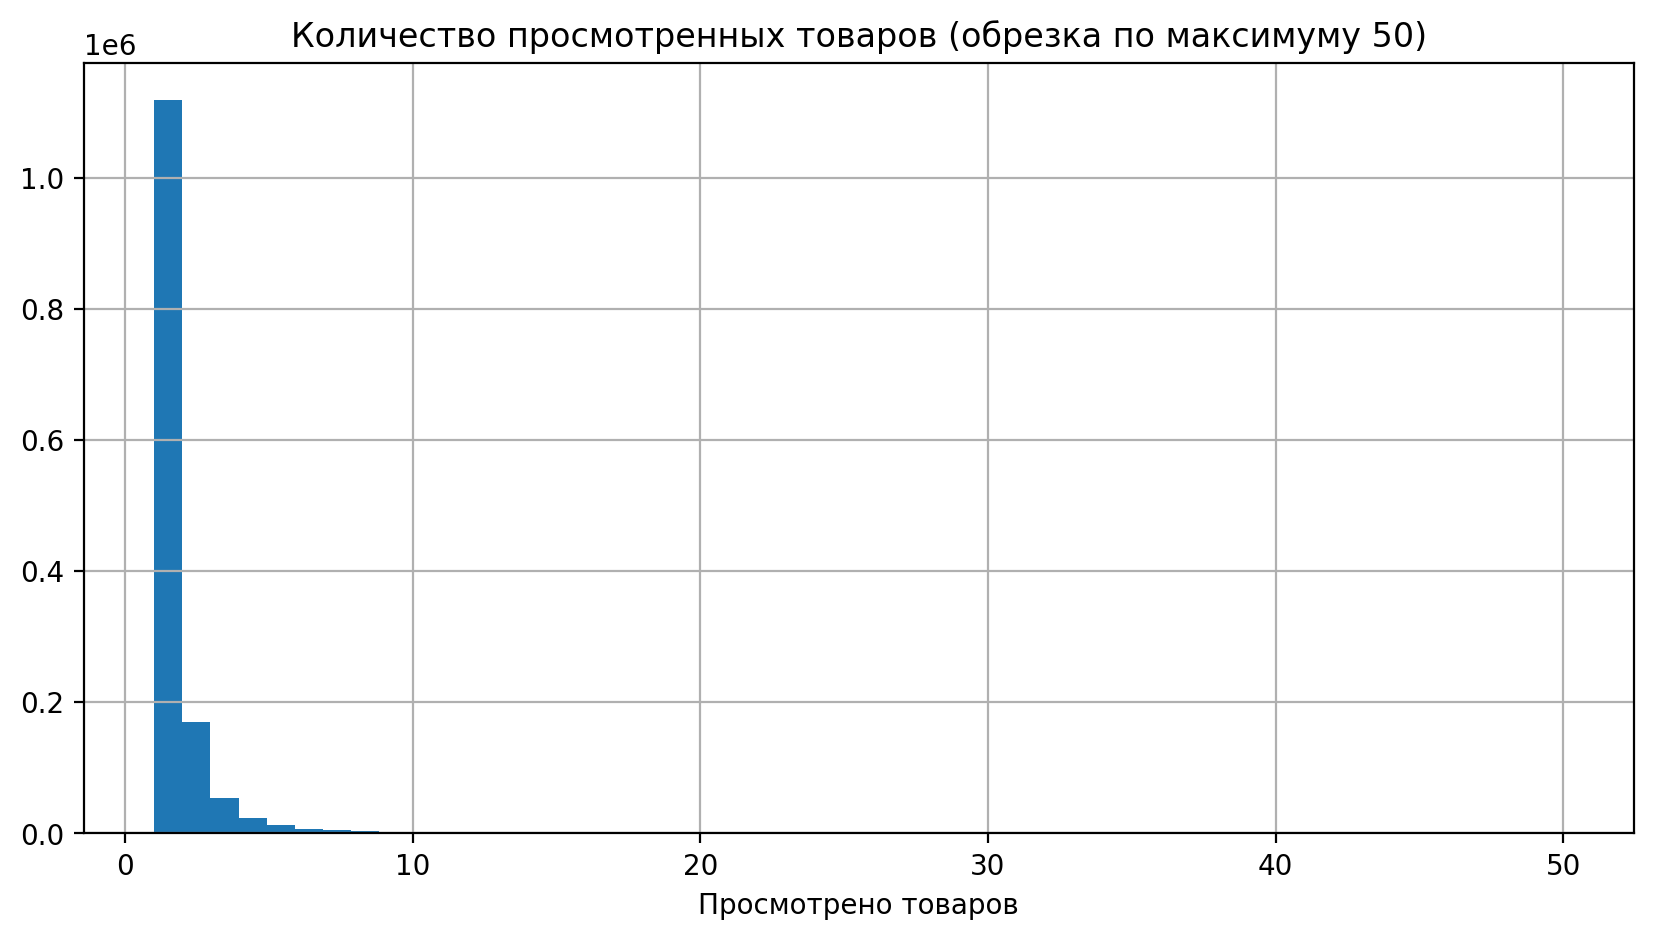

In [130]:
# количество просмотренных товаров на посетителя
# Фильтруем только события "просмотра"
views = events[events['event'] == 'view']

# Группируем по пользователю и считаем количество уникальных просмотренных товаров
views_per_visitor = (
    views.groupby('visitorid')['itemid']
    .nunique()        # количество уникальных товаров
    .reset_index()
    .rename(columns={'itemid': 'n_viewed_items'})
)

# Смотрим результат
print(views_per_visitor.head())

plt.figure(figsize=(10,5))
views_per_visitor['n_viewed_items'].clip(upper=50).hist(bins=50)
plt.title('Количество просмотренных товаров (обрезка по максимуму 50)')
plt.xlabel('Просмотрено товаров')
plt.savefig('./EDA/visitor_item_counts.png')
plt.show()

Как видим большинство пользователей просматривают мало товаров (1–5)

Посчитаем топ-20 самых популярных товаров по количеству событий (например, просмотров).

In [133]:
# Считаем количество событий по каждому товару
top_items = (
    events.groupby("itemid")
    .size()
    .reset_index(name="event_count")
    .sort_values("event_count", ascending=False)
    .head(20)
)

top_items

,itemid,event_count
94720,187946,3412
232496,461686,2978
2719,5411,2334
186716,370653,1854
110536,219512,1800
129504,257040,1647
150148,298009,1642
49024,96924,1633
156023,309778,1628
193605,384302,1608


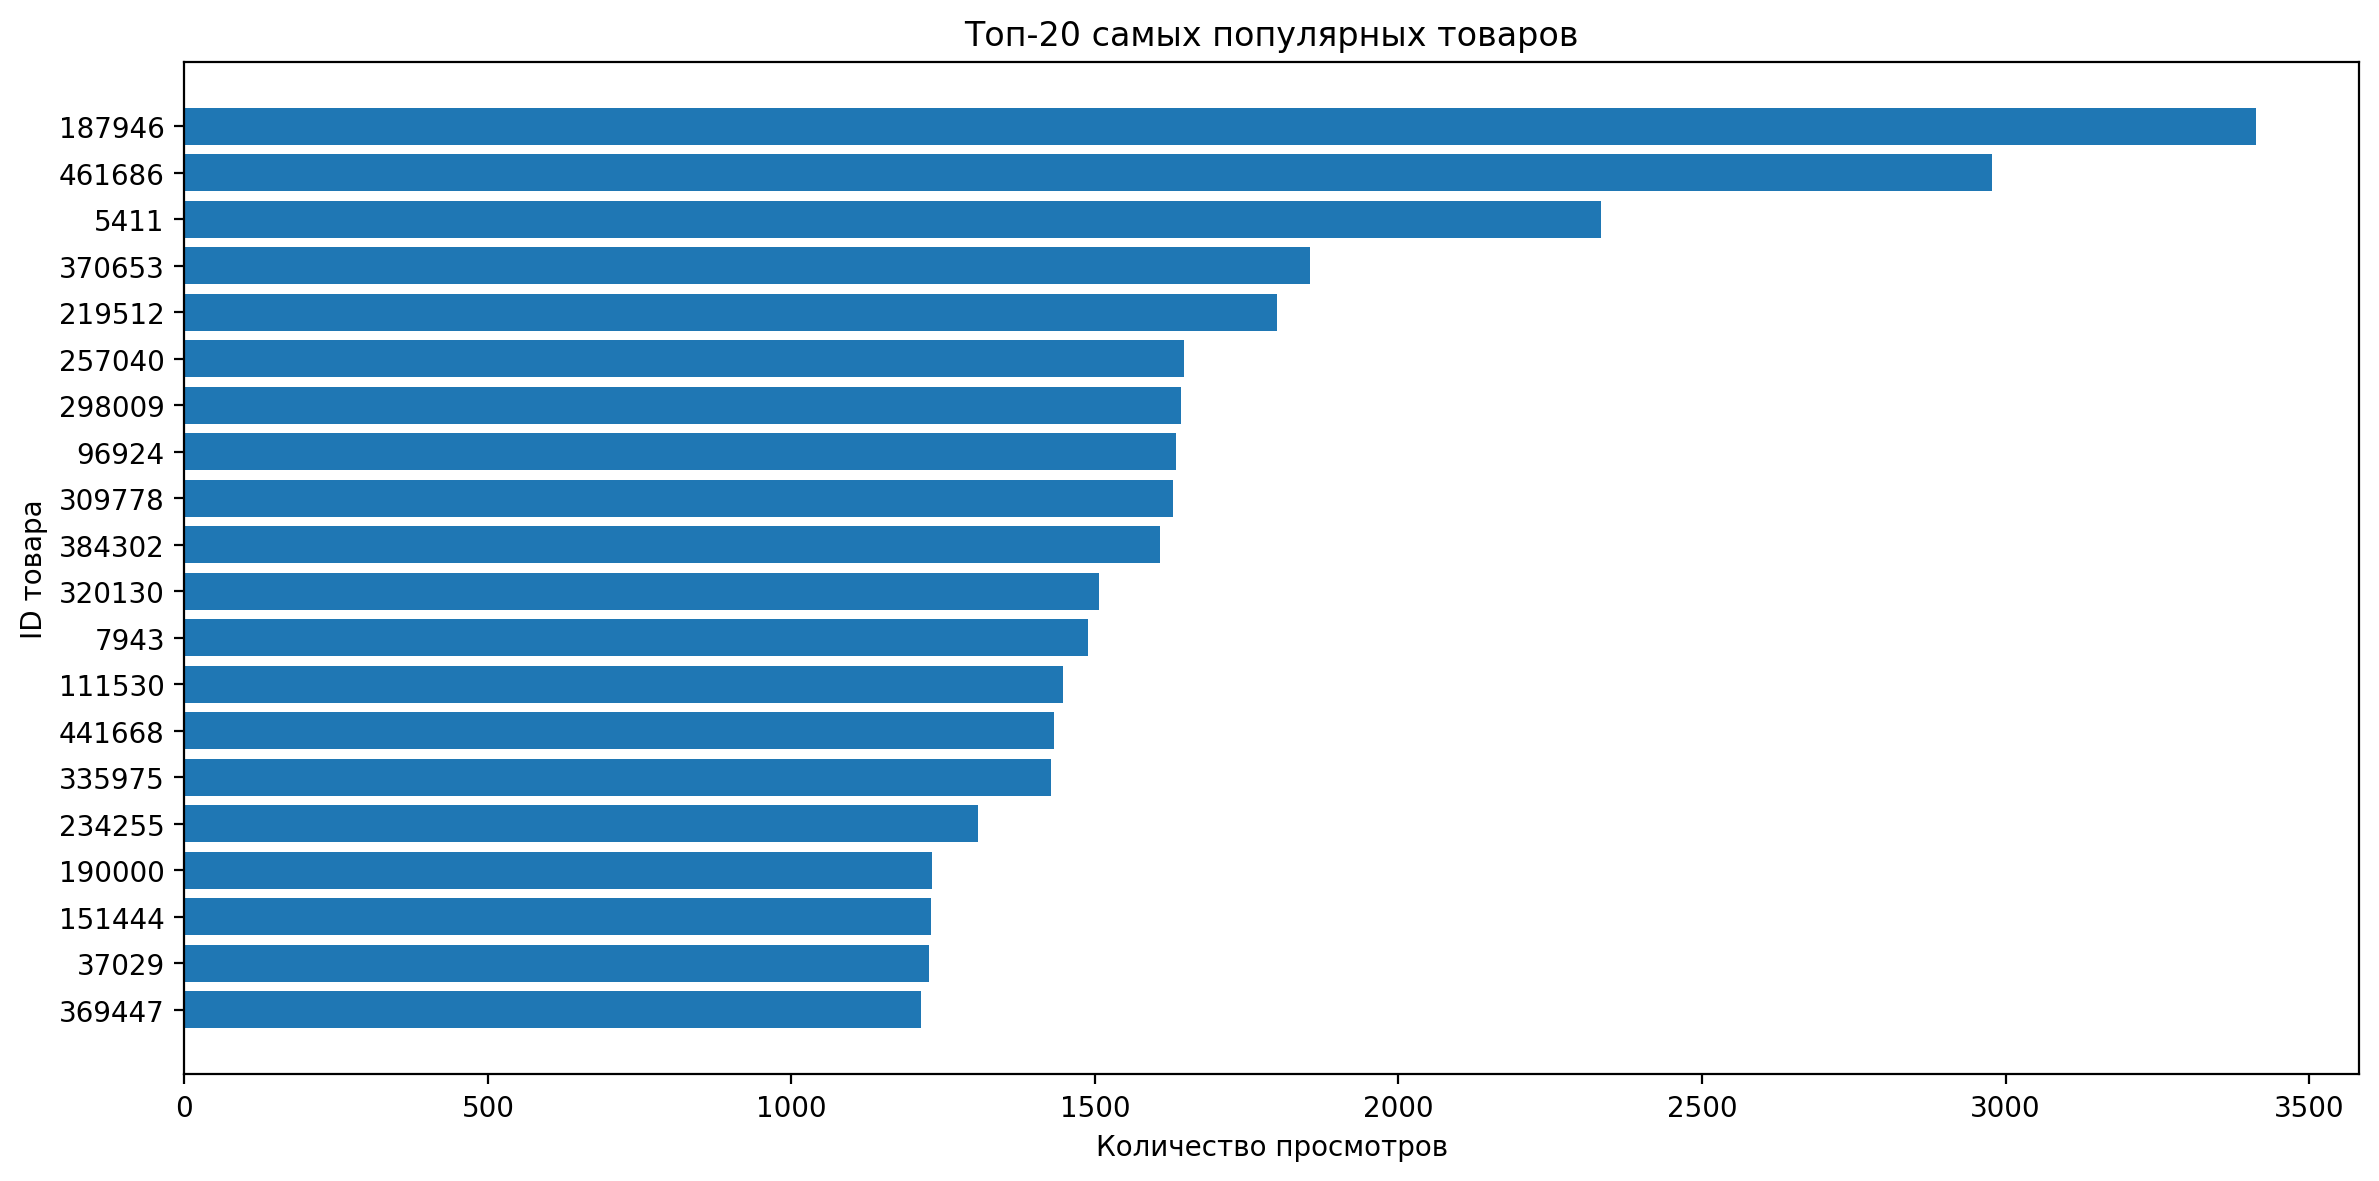

In [137]:
plt.figure(figsize=(12,6))
plt.barh(top_items["itemid"].astype(str), top_items["event_count"])
plt.gca().invert_yaxis()  # чтобы самый популярный был сверху
plt.title("Топ-20 самых популярных товаров")
plt.xlabel("Количество просмотров")
plt.ylabel("ID товара")
plt.tight_layout()
plt.savefig('./EDA/top-20_items.png')
plt.show()

Посмотри только просмотры, отфильтруем по event == 'view':

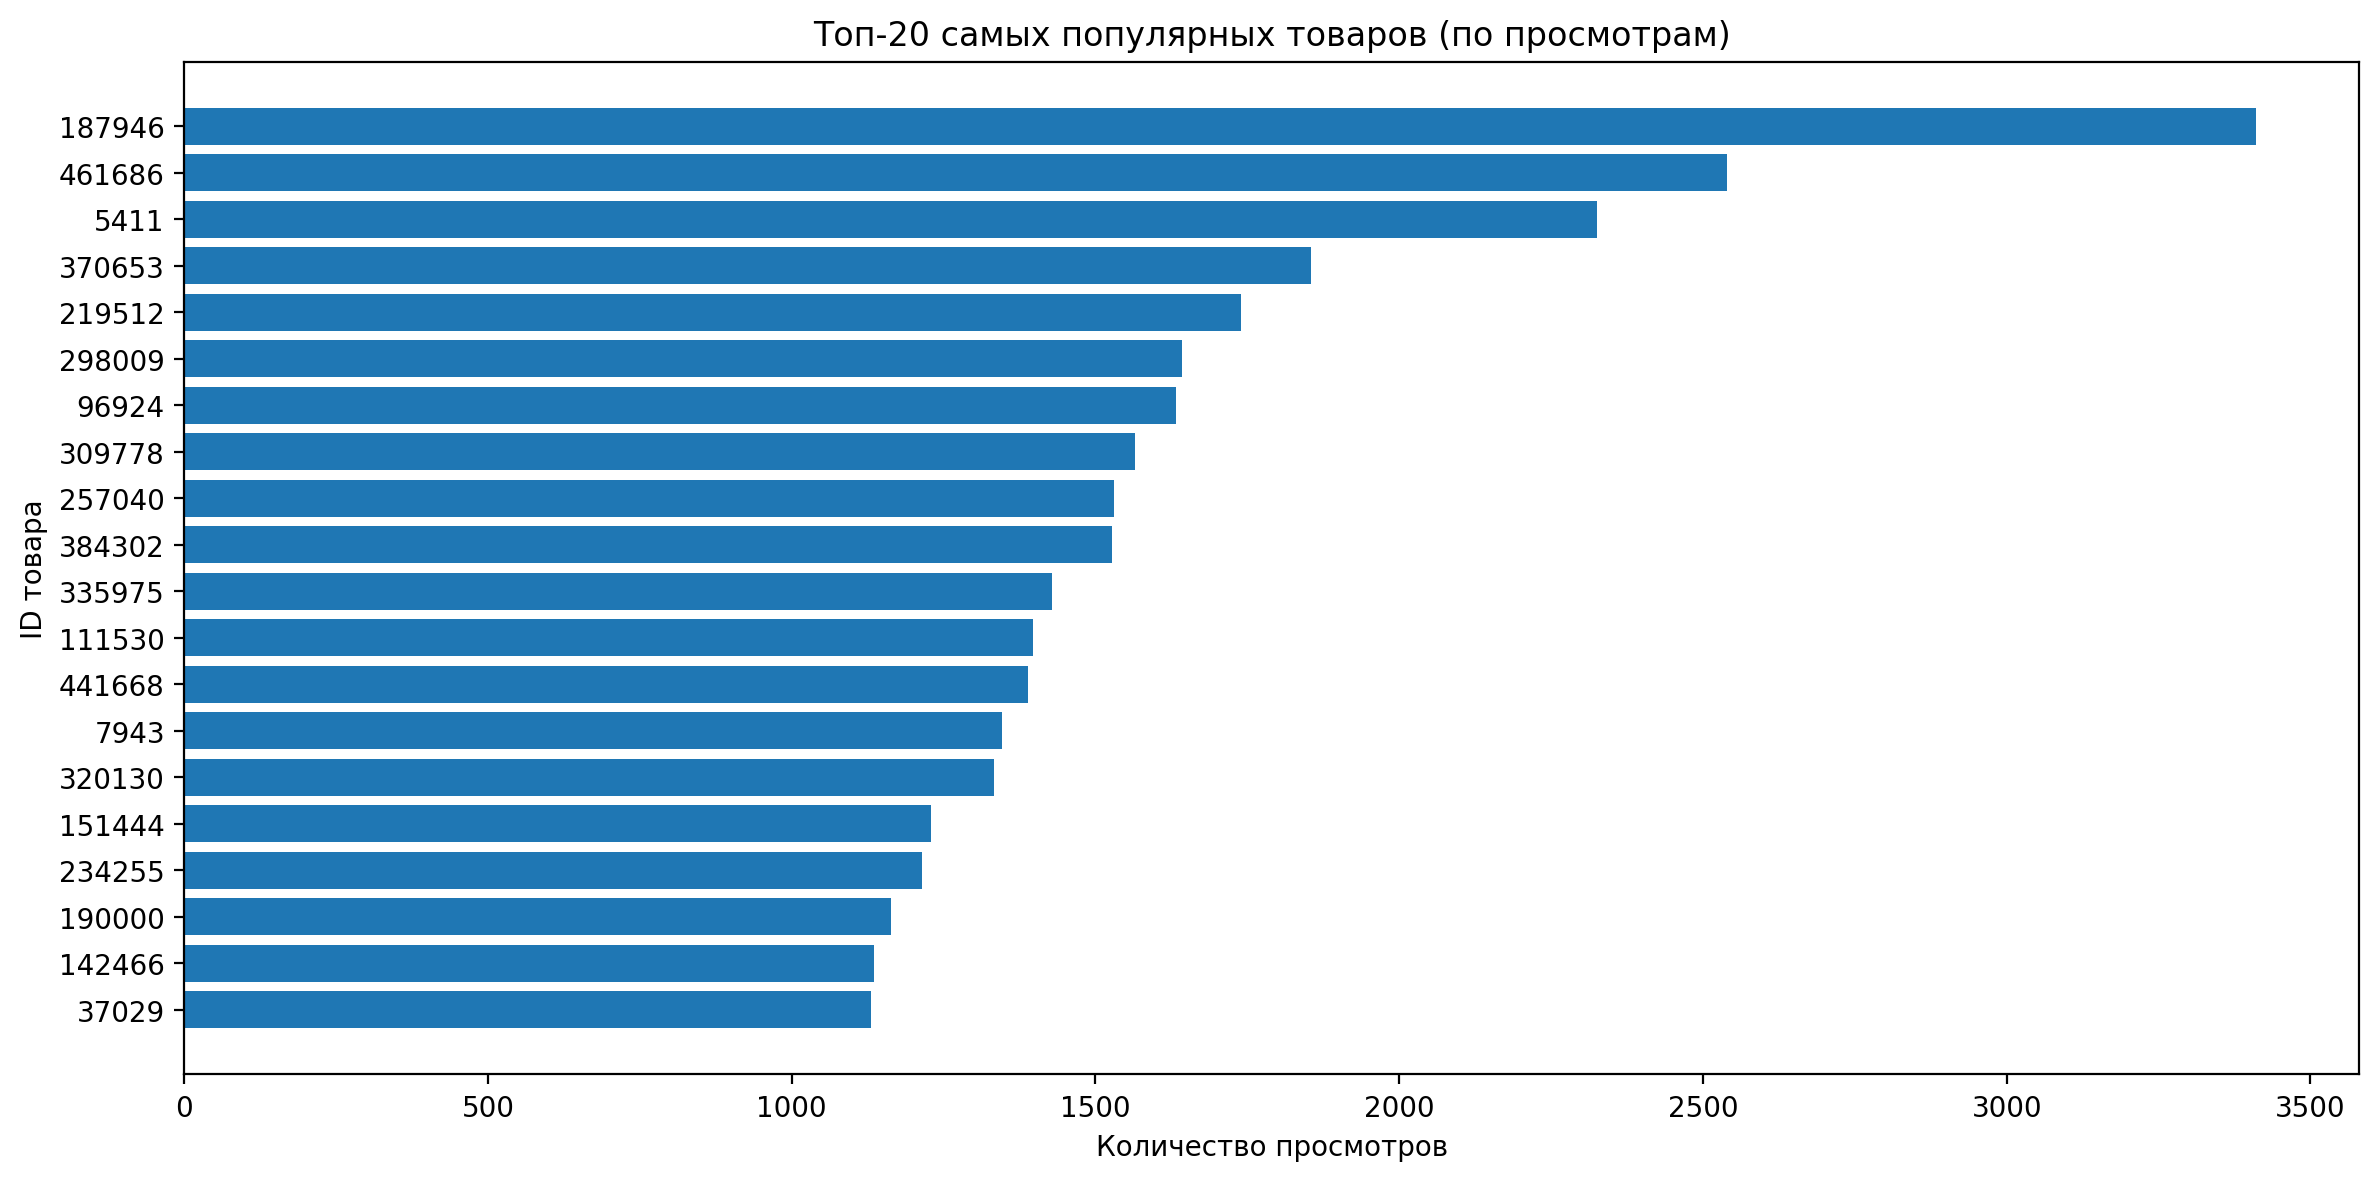

In [138]:
top_items_view = (
    events[events["event"] == "view"]
    .groupby("itemid")
    .size()
    .reset_index(name="view_count")
    .sort_values("view_count", ascending=False)
    .head(20)
)

plt.figure(figsize=(12,6))
plt.barh(top_items_view["itemid"].astype(str), top_items_view["view_count"])
plt.gca().invert_yaxis()  # чтобы самый популярный был сверху
plt.title("Топ-20 самых популярных товаров (по просмотрам)")
plt.xlabel("Количество просмотров")
plt.ylabel("ID товара")
plt.tight_layout()
plt.savefig('./EDA/top-20_view_items.png')
plt.show()

почти теже самые товары

Добавим к топ-20 по просмотрам ещё один слой — покупки, чтобы видеть конверсию (что из того, что смотрели, чаще всего покупали)

In [139]:
# --- Топ-20 по просмотрам ---
top_items_view = (
    events[events["event"] == "view"]
    .groupby("itemid")
    .size()
    .reset_index(name="view_count")
    .sort_values("view_count", ascending=False)
    .head(20)
)

# --- Покупки по этим же товарам ---
top_items_purchase = (
    events[(events["event"] == "transaction") & (events["itemid"].isin(top_items_view["itemid"]))]
    .groupby("itemid")
    .size()
    .reset_index(name="purchase_count")
)


In [140]:
# --- Объединяем просмотры и покупки ---
top_items_stats = top_items_view.merge(top_items_purchase, on="itemid", how="left").fillna(0)

In [141]:
# --- Добавляем конверсию ---
top_items_stats["conversion_rate"] = top_items_stats["purchase_count"] / top_items_stats["view_count"]


In [142]:
# --- Сортируем по количеству просмотров (чтобы не перепутать порядок в графике) ---
top_items_stats = top_items_stats.sort_values("view_count", ascending=True)

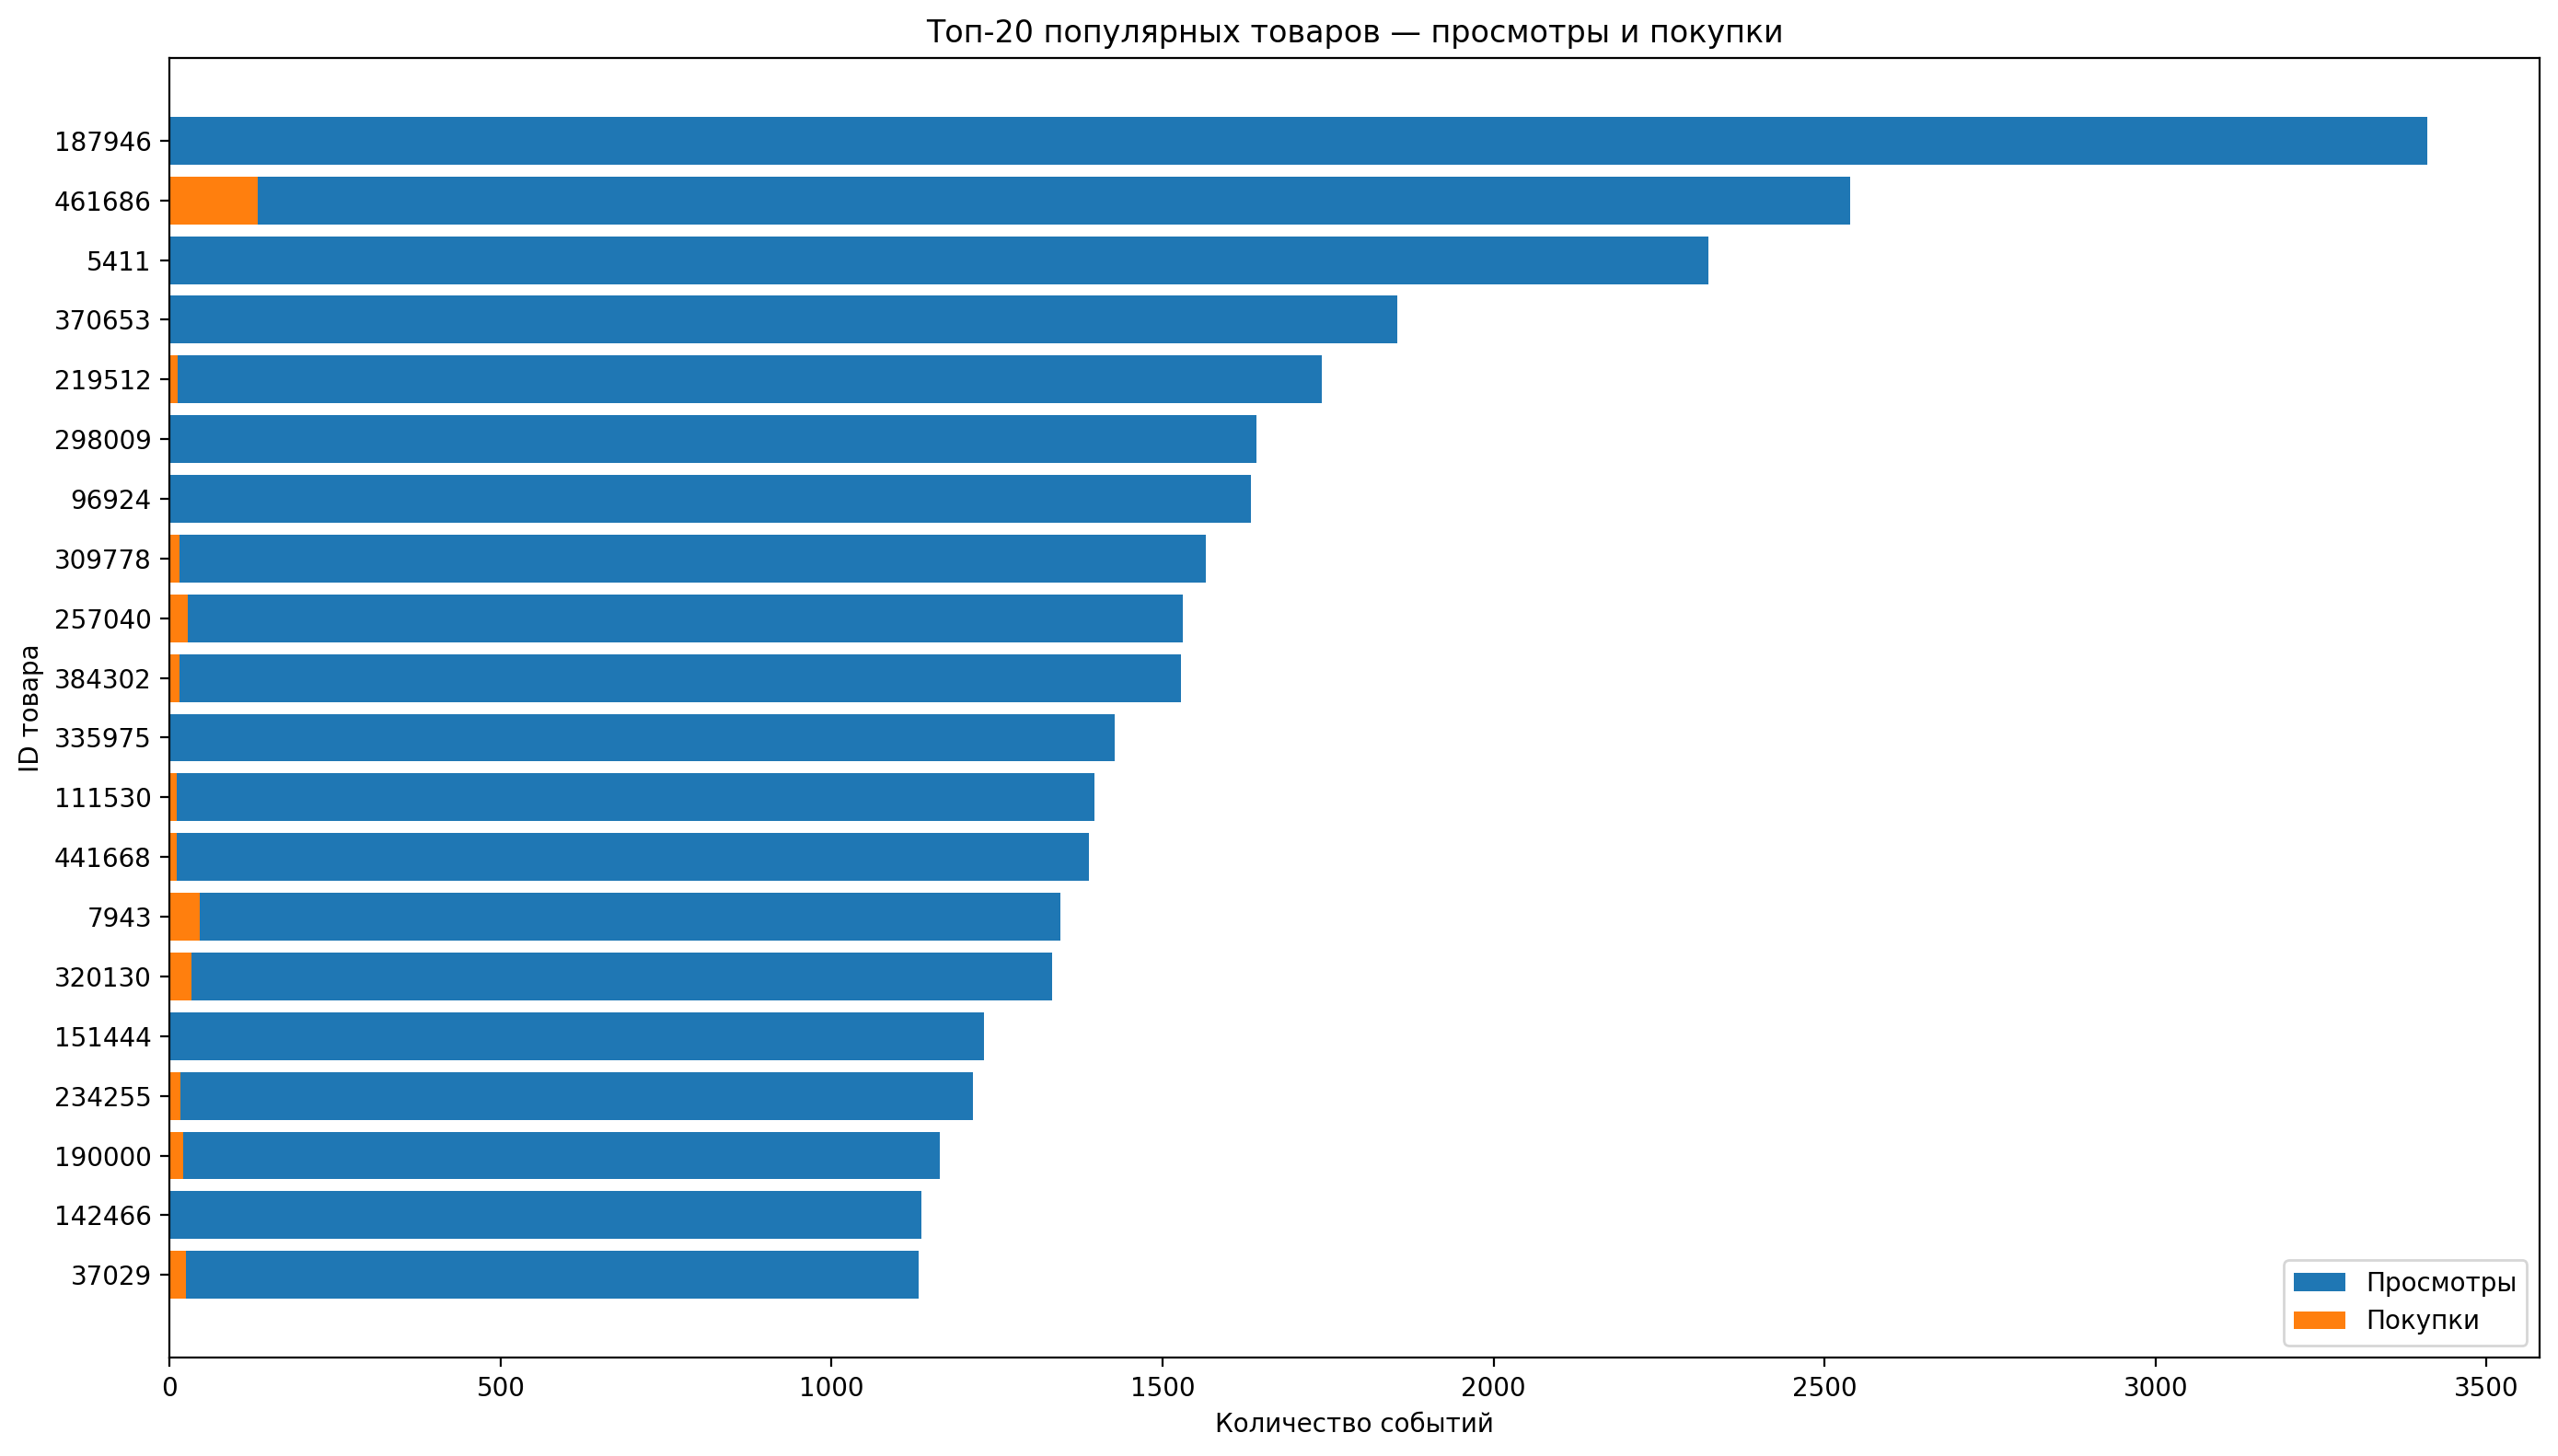

In [143]:
# --- Строим stacked bar chart ---
plt.figure(figsize=(14,8))
plt.barh(top_items_stats["itemid"].astype(str), top_items_stats["view_count"], label="Просмотры")
plt.barh(top_items_stats["itemid"].astype(str), top_items_stats["purchase_count"], label="Покупки")

plt.title("Топ-20 популярных товаров — просмотры и покупки")
plt.xlabel("Количество событий")
plt.ylabel("ID товара")
plt.legend()
plt.tight_layout()
plt.savefig('./EDA/top-20_view_vs_by_items.png')
plt.show()

In [144]:
# --- Дополнительно: вывести таблицу конверсии ---
top_items_stats_sorted = top_items_stats.sort_values("conversion_rate", ascending=False)
display(top_items_stats_sorted[["itemid", "view_count", "purchase_count", "conversion_rate"]])

,itemid,view_count,purchase_count,conversion_rate
1,461686,2539,133.0,0.052383
13,7943,1346,46.0,0.034175
14,320130,1333,33.0,0.024756
19,37029,1131,25.0,0.022104
8,257040,1531,27.0,0.017636
17,190000,1164,20.0,0.017182
16,234255,1214,16.0,0.013180
9,384302,1528,15.0,0.009817
7,309778,1565,15.0,0.009585
12,441668,1389,11.0,0.007919


можно быстро увидеть:
- какие товары чаще всего конвертируются в покупку (высокий conversion_rate),
- а какие просто часто смотрят, но не покупают (низкий conversion_rate).

Построим отдельный график топ-20 товаров по конверсии (доля покупок от просмотров):

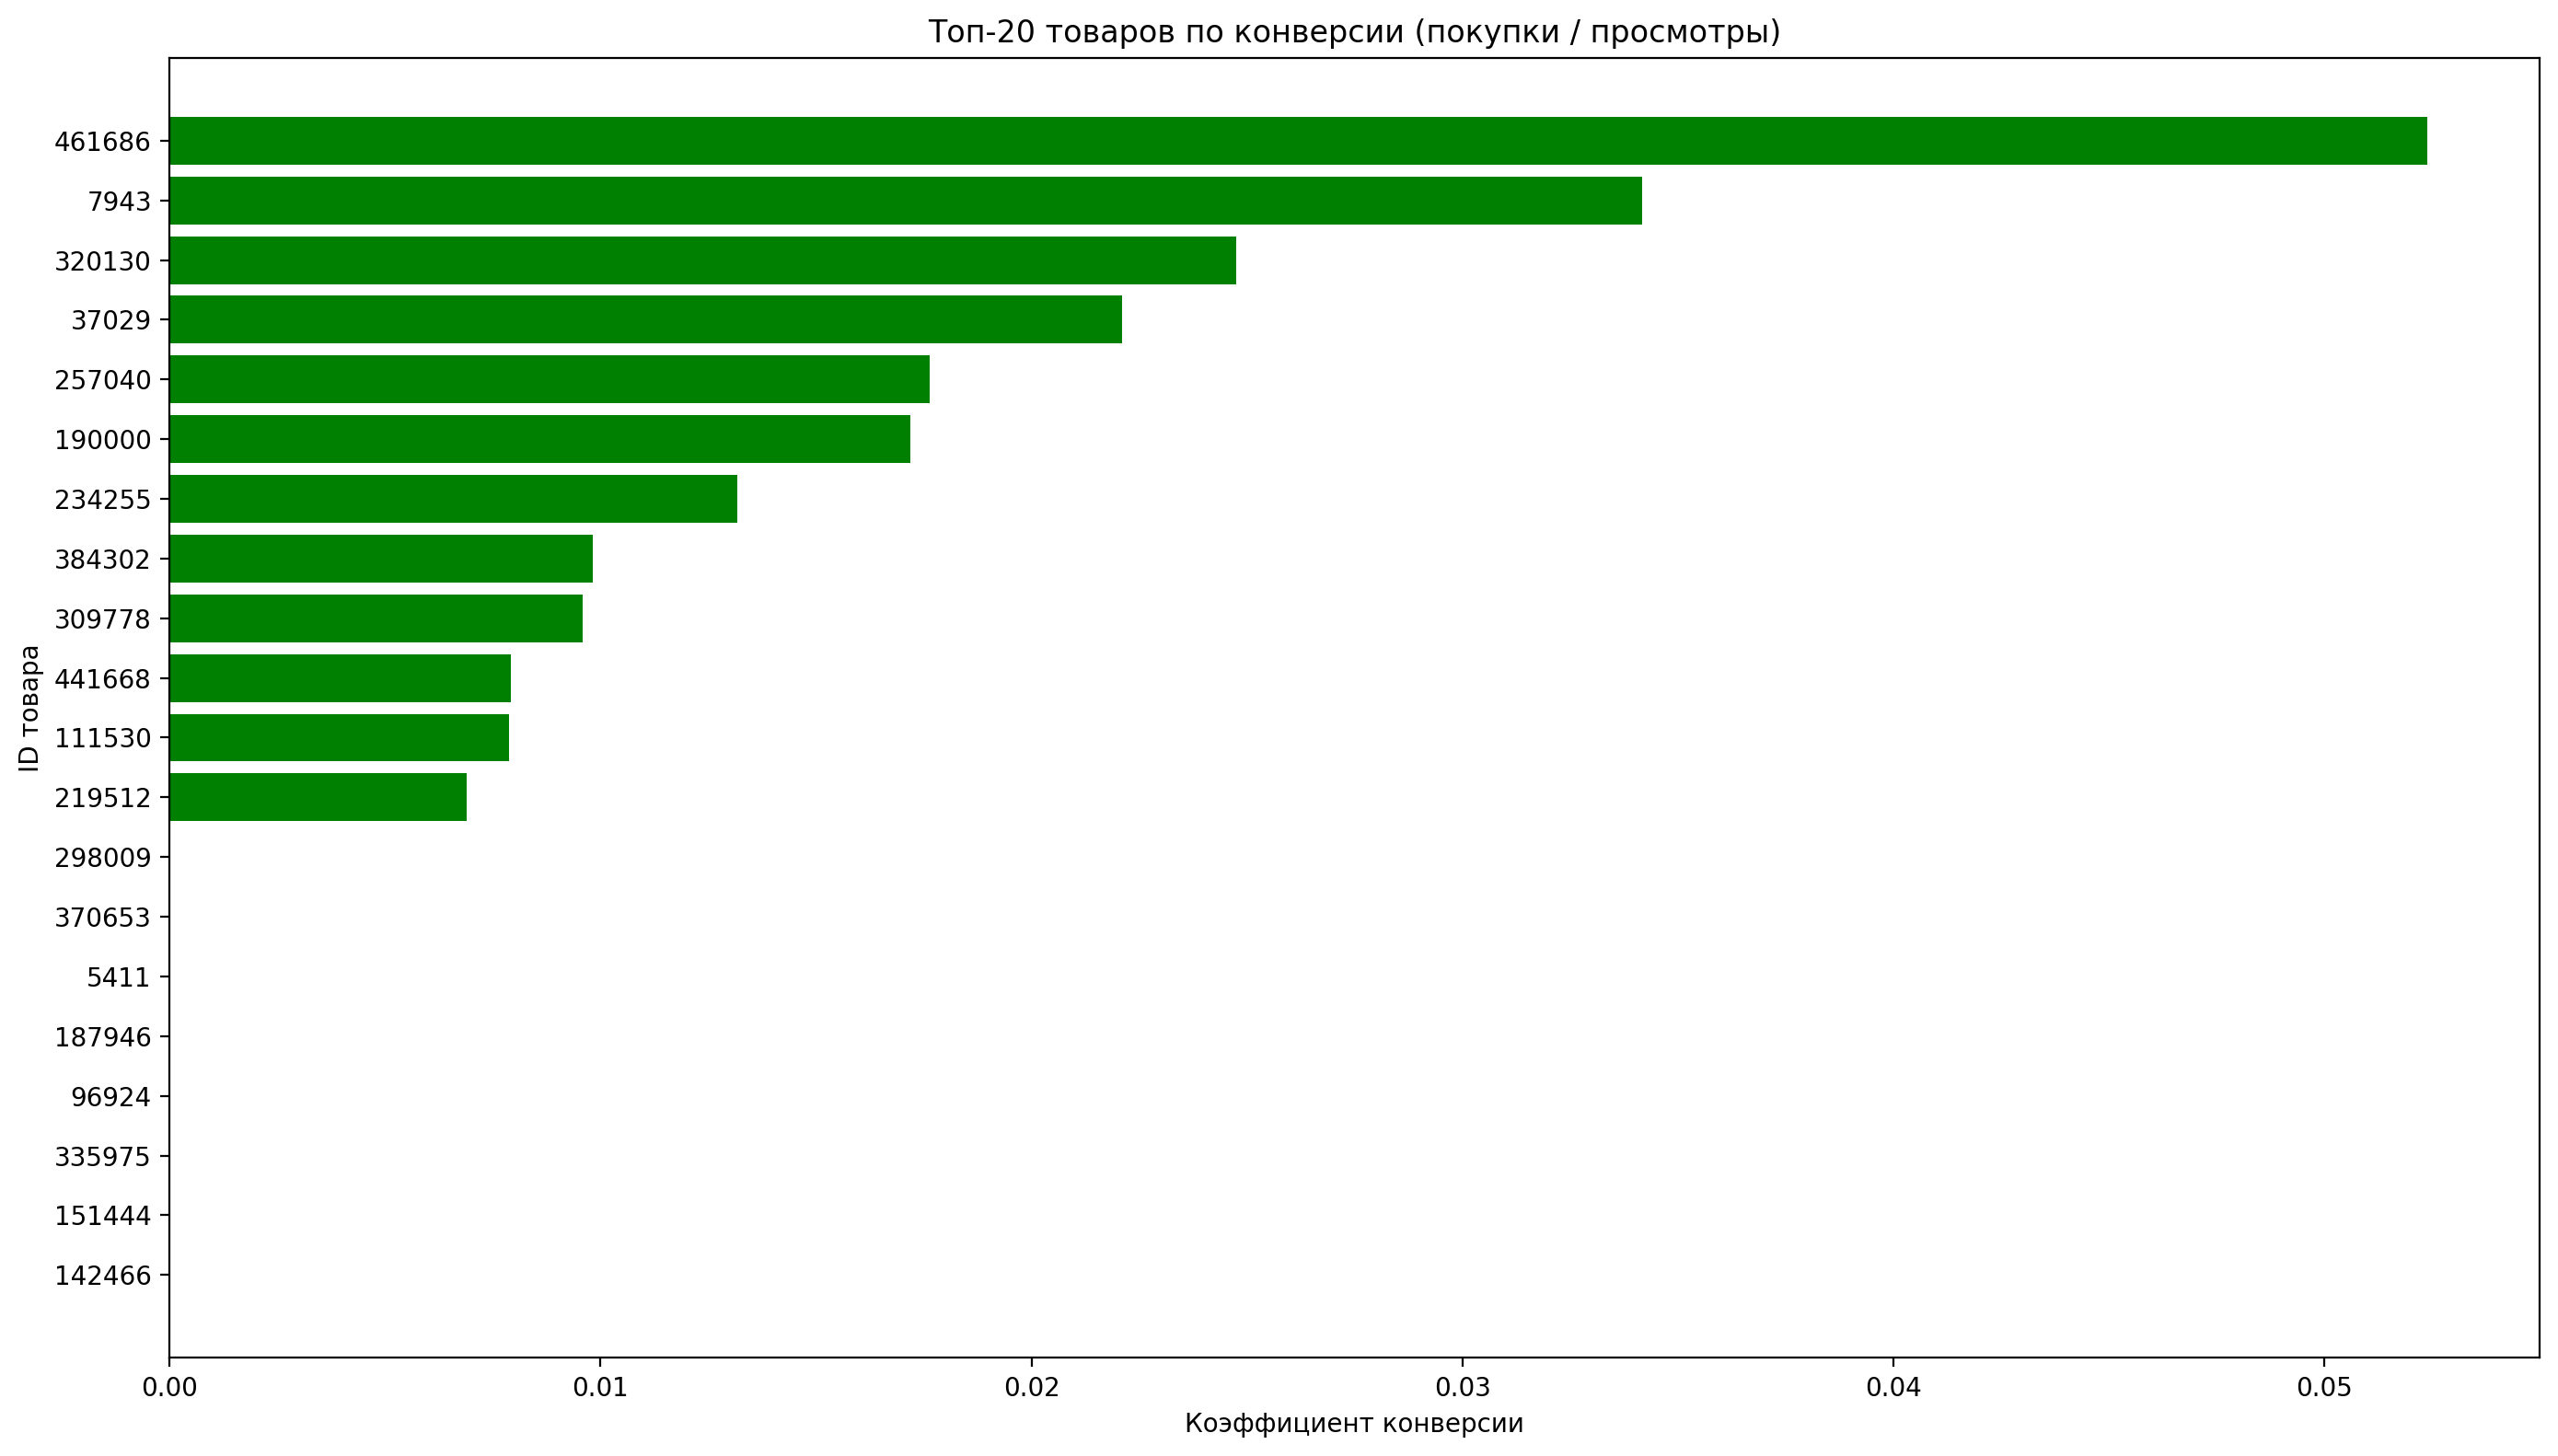

In [145]:
# --- Топ по конверсии ---
top_items_by_conversion = (
    top_items_stats.sort_values("conversion_rate", ascending=False)
    .head(20)
    .sort_values("conversion_rate", ascending=True)
)

plt.figure(figsize=(14,8))
plt.barh(
    top_items_by_conversion["itemid"].astype(str),
    top_items_by_conversion["conversion_rate"],
    color="green"
)
plt.title("Топ-20 товаров по конверсии (покупки / просмотры)")
plt.xlabel("Коэффициент конверсии")
plt.ylabel("ID товара")
plt.tight_layout()
plt.savefig('./EDA/top-20_conv_by_vs_view_items.png')
plt.show()

- Видим товары с самой высокой эффективностью продаж: высокий процент людей, которые не только смотрят, но и покупают.
- Хорошо помогает находить товары для промо — их выгодно рекомендовать.

Добавим к топ-20 по просмотрам ещё один слой — добавление в корзину, чтобы видеть конверсию (что из того, что смотрели, чаще всего добавляли в корзину)

In [ ]:
# --- Топ-20 по просмотрам ---
top_items_view = (
    events[events["event"] == "view"]
    .groupby("itemid")
    .size()
    .reset_index(name="view_count")
    .sort_values("view_count", ascending=False)
    .head(20)
)

# --- Добавили в корзину по этим же товарам ---
top_items_purchase = (
    events[(events["event"] == "addtocart") & (events["itemid"].isin(top_items_view["itemid"]))]
    .groupby("itemid")
    .size()
    .reset_index(name="purchase_count")
)

In [149]:
# --- Объединяем просмотры и добавление в корзину ---
top_items_stats = top_items_view.merge(top_items_purchase, on="itemid", how="left").fillna(0)

# --- Добавляем конверсию ---
top_items_stats["conversion_rate"] = top_items_stats["purchase_count"] / top_items_stats["view_count"]

# --- Сортируем по количеству просмотров (чтобы не перепутать порядок в графике) ---
top_items_stats = top_items_stats.sort_values("view_count", ascending=True)

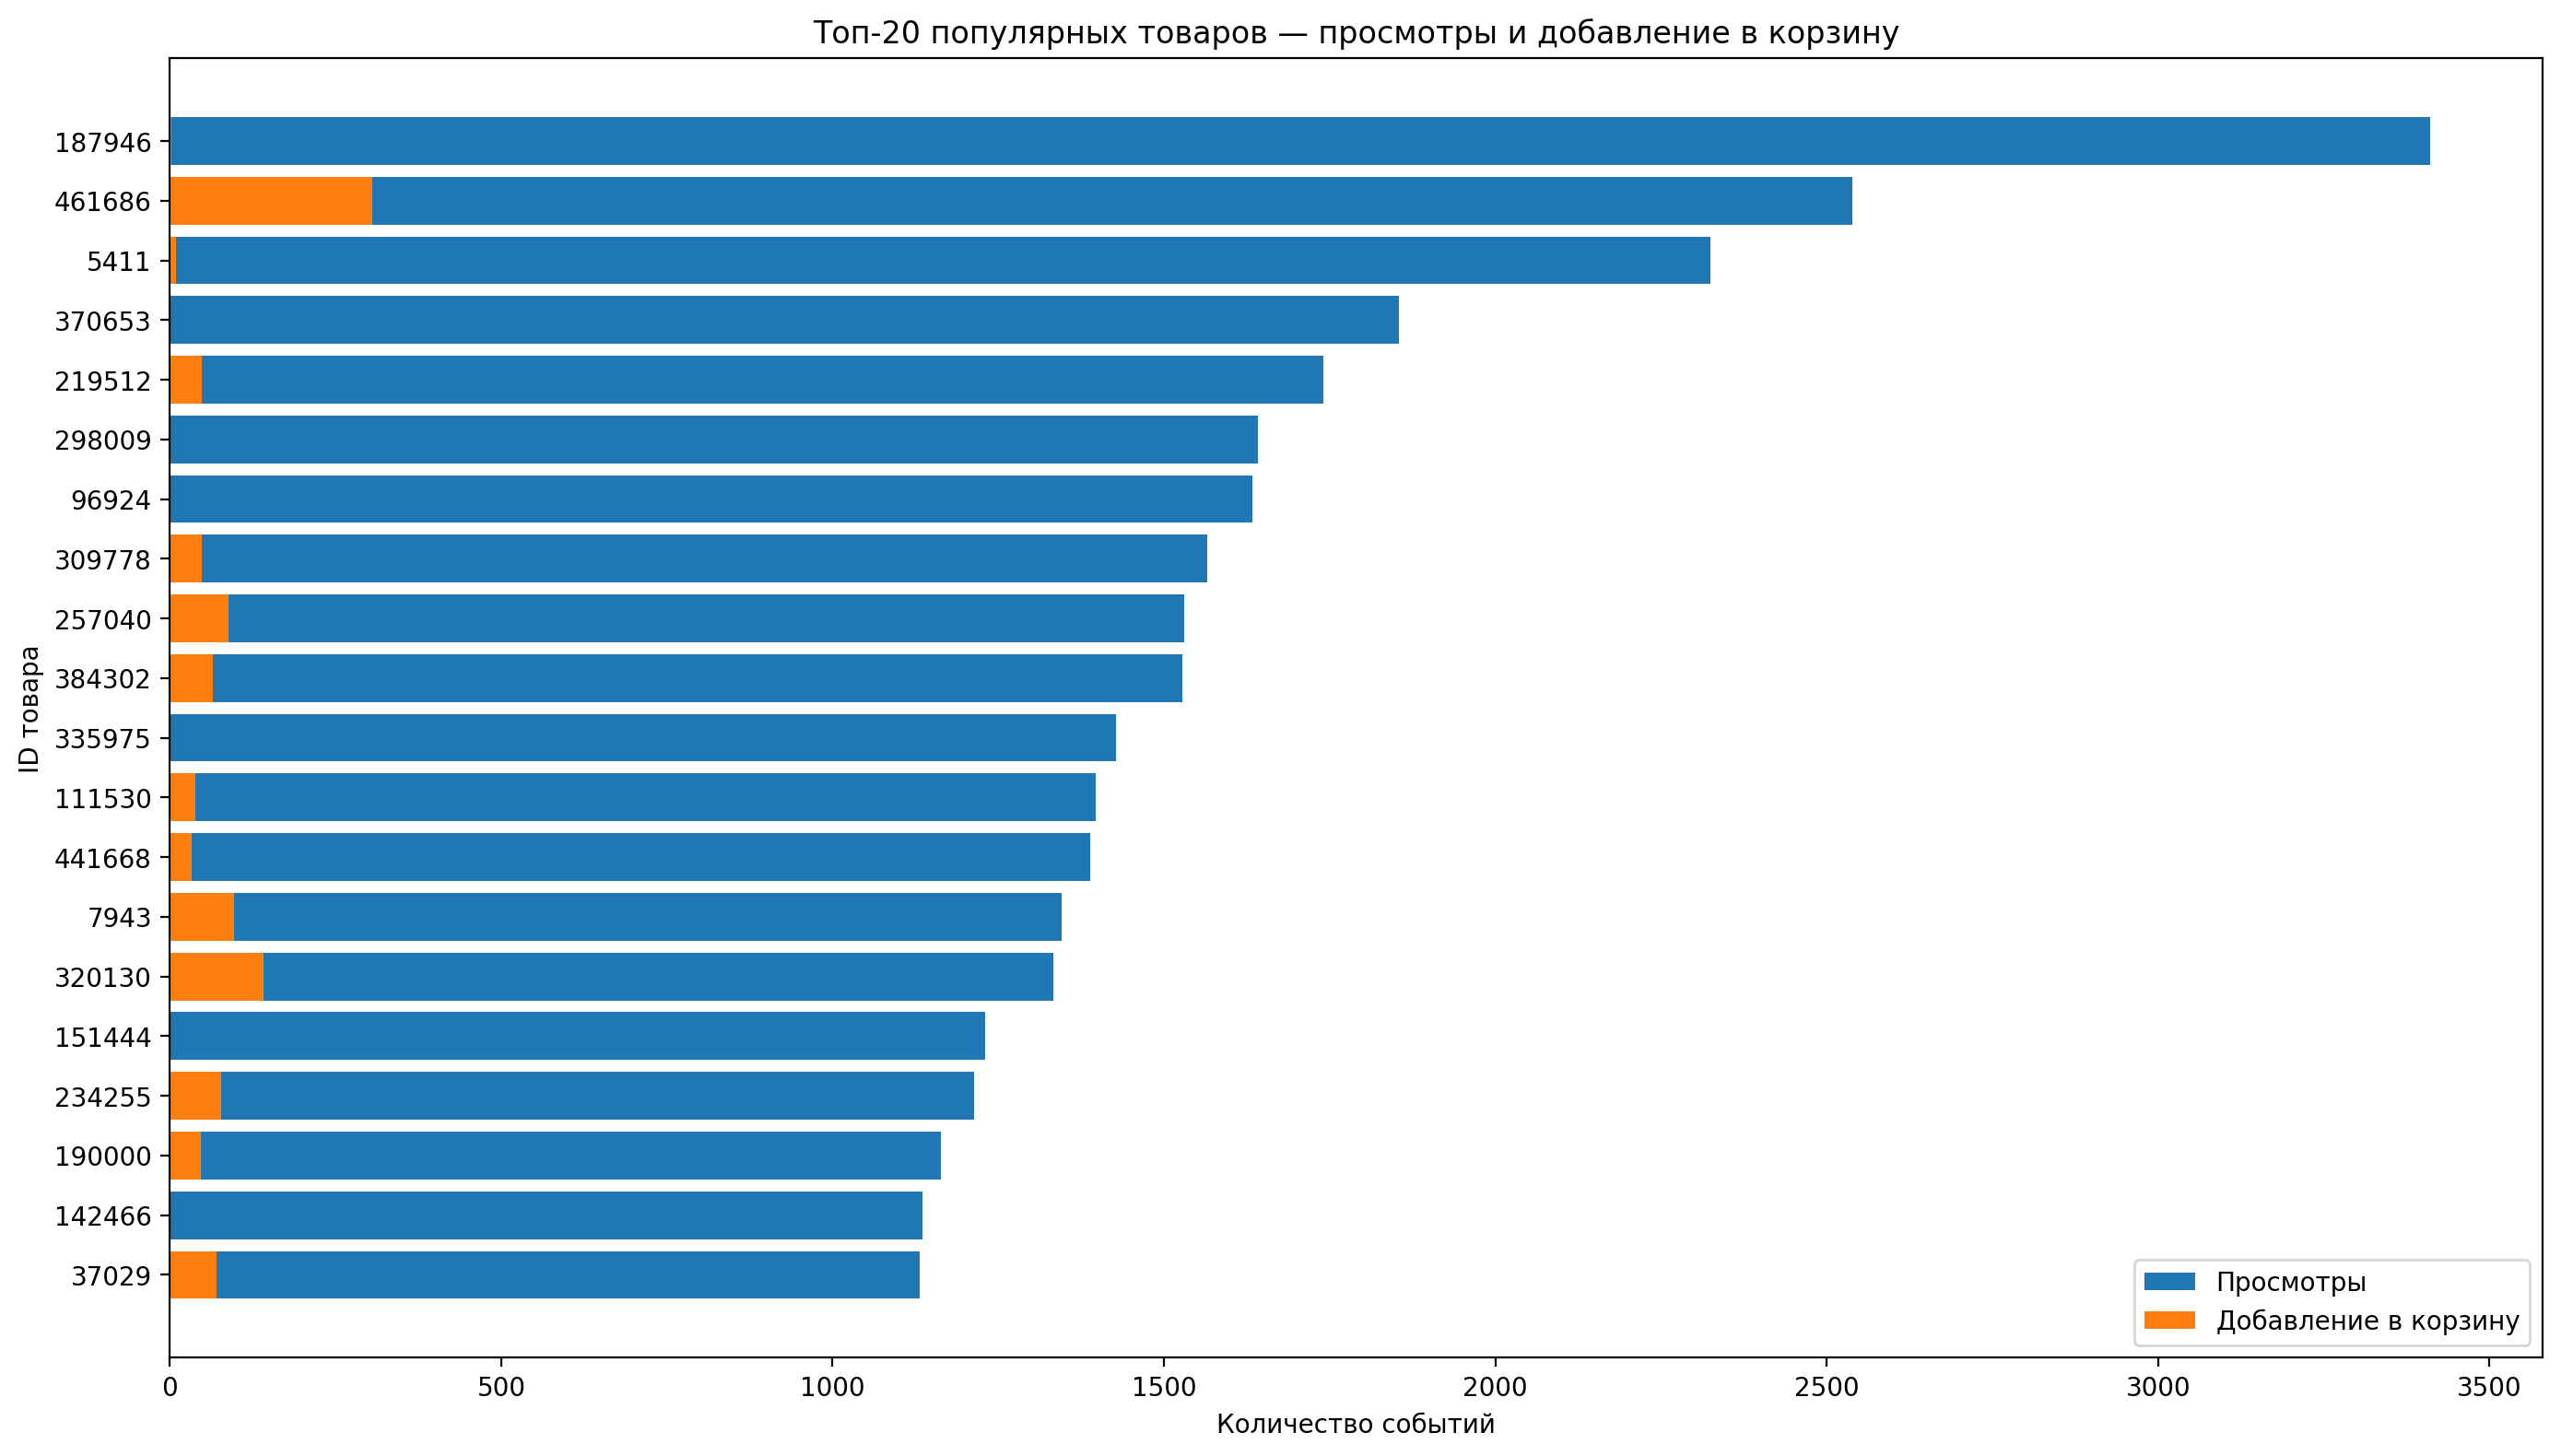

In [150]:
# --- Строим stacked bar chart ---
plt.figure(figsize=(14,8))
plt.barh(top_items_stats["itemid"].astype(str), top_items_stats["view_count"], label="Просмотры")
plt.barh(top_items_stats["itemid"].astype(str), top_items_stats["purchase_count"], label="Добавление в корзину")

plt.title("Топ-20 популярных товаров — просмотры и добавление в корзину")
plt.xlabel("Количество событий")
plt.ylabel("ID товара")
plt.legend()
plt.tight_layout()
plt.savefig('./EDA/top-20_view_vs_addtocart_items.png')
plt.show()

Добавим к топ-20 по добавлению в корзину ещё один слой — покупка, чтобы видеть конверсию (что из того, что положили в корзину, чаще всего покупали)

In [153]:
# --- Топ-20 по корзине ---
top_items_addtocart = (
    events[events["event"] == "addtocart"]
    .groupby("itemid")
    .size()
    .reset_index(name="add_count")
    .sort_values("add_count", ascending=False)
    .head(20)
)

# --- Покупки по этим же товарам ---
top_items_purchase = (
    events[(events["event"] == "transaction") & (events["itemid"].isin(top_items_addtocart["itemid"]))]
    .groupby("itemid")
    .size()
    .reset_index(name="purchase_count")
)

In [154]:
# --- Объединяем просмотры и добавление в корзину ---
top_items_stats = top_items_addtocart.merge(top_items_purchase, on="itemid", how="left").fillna(0)

# --- Добавляем конверсию ---
top_items_stats["conversion_rate"] = top_items_stats["purchase_count"] / top_items_stats["add_count"]

# --- Сортируем по количеству просмотров (чтобы не перепутать порядок в графике) ---
top_items_stats = top_items_stats.sort_values("add_count", ascending=True)

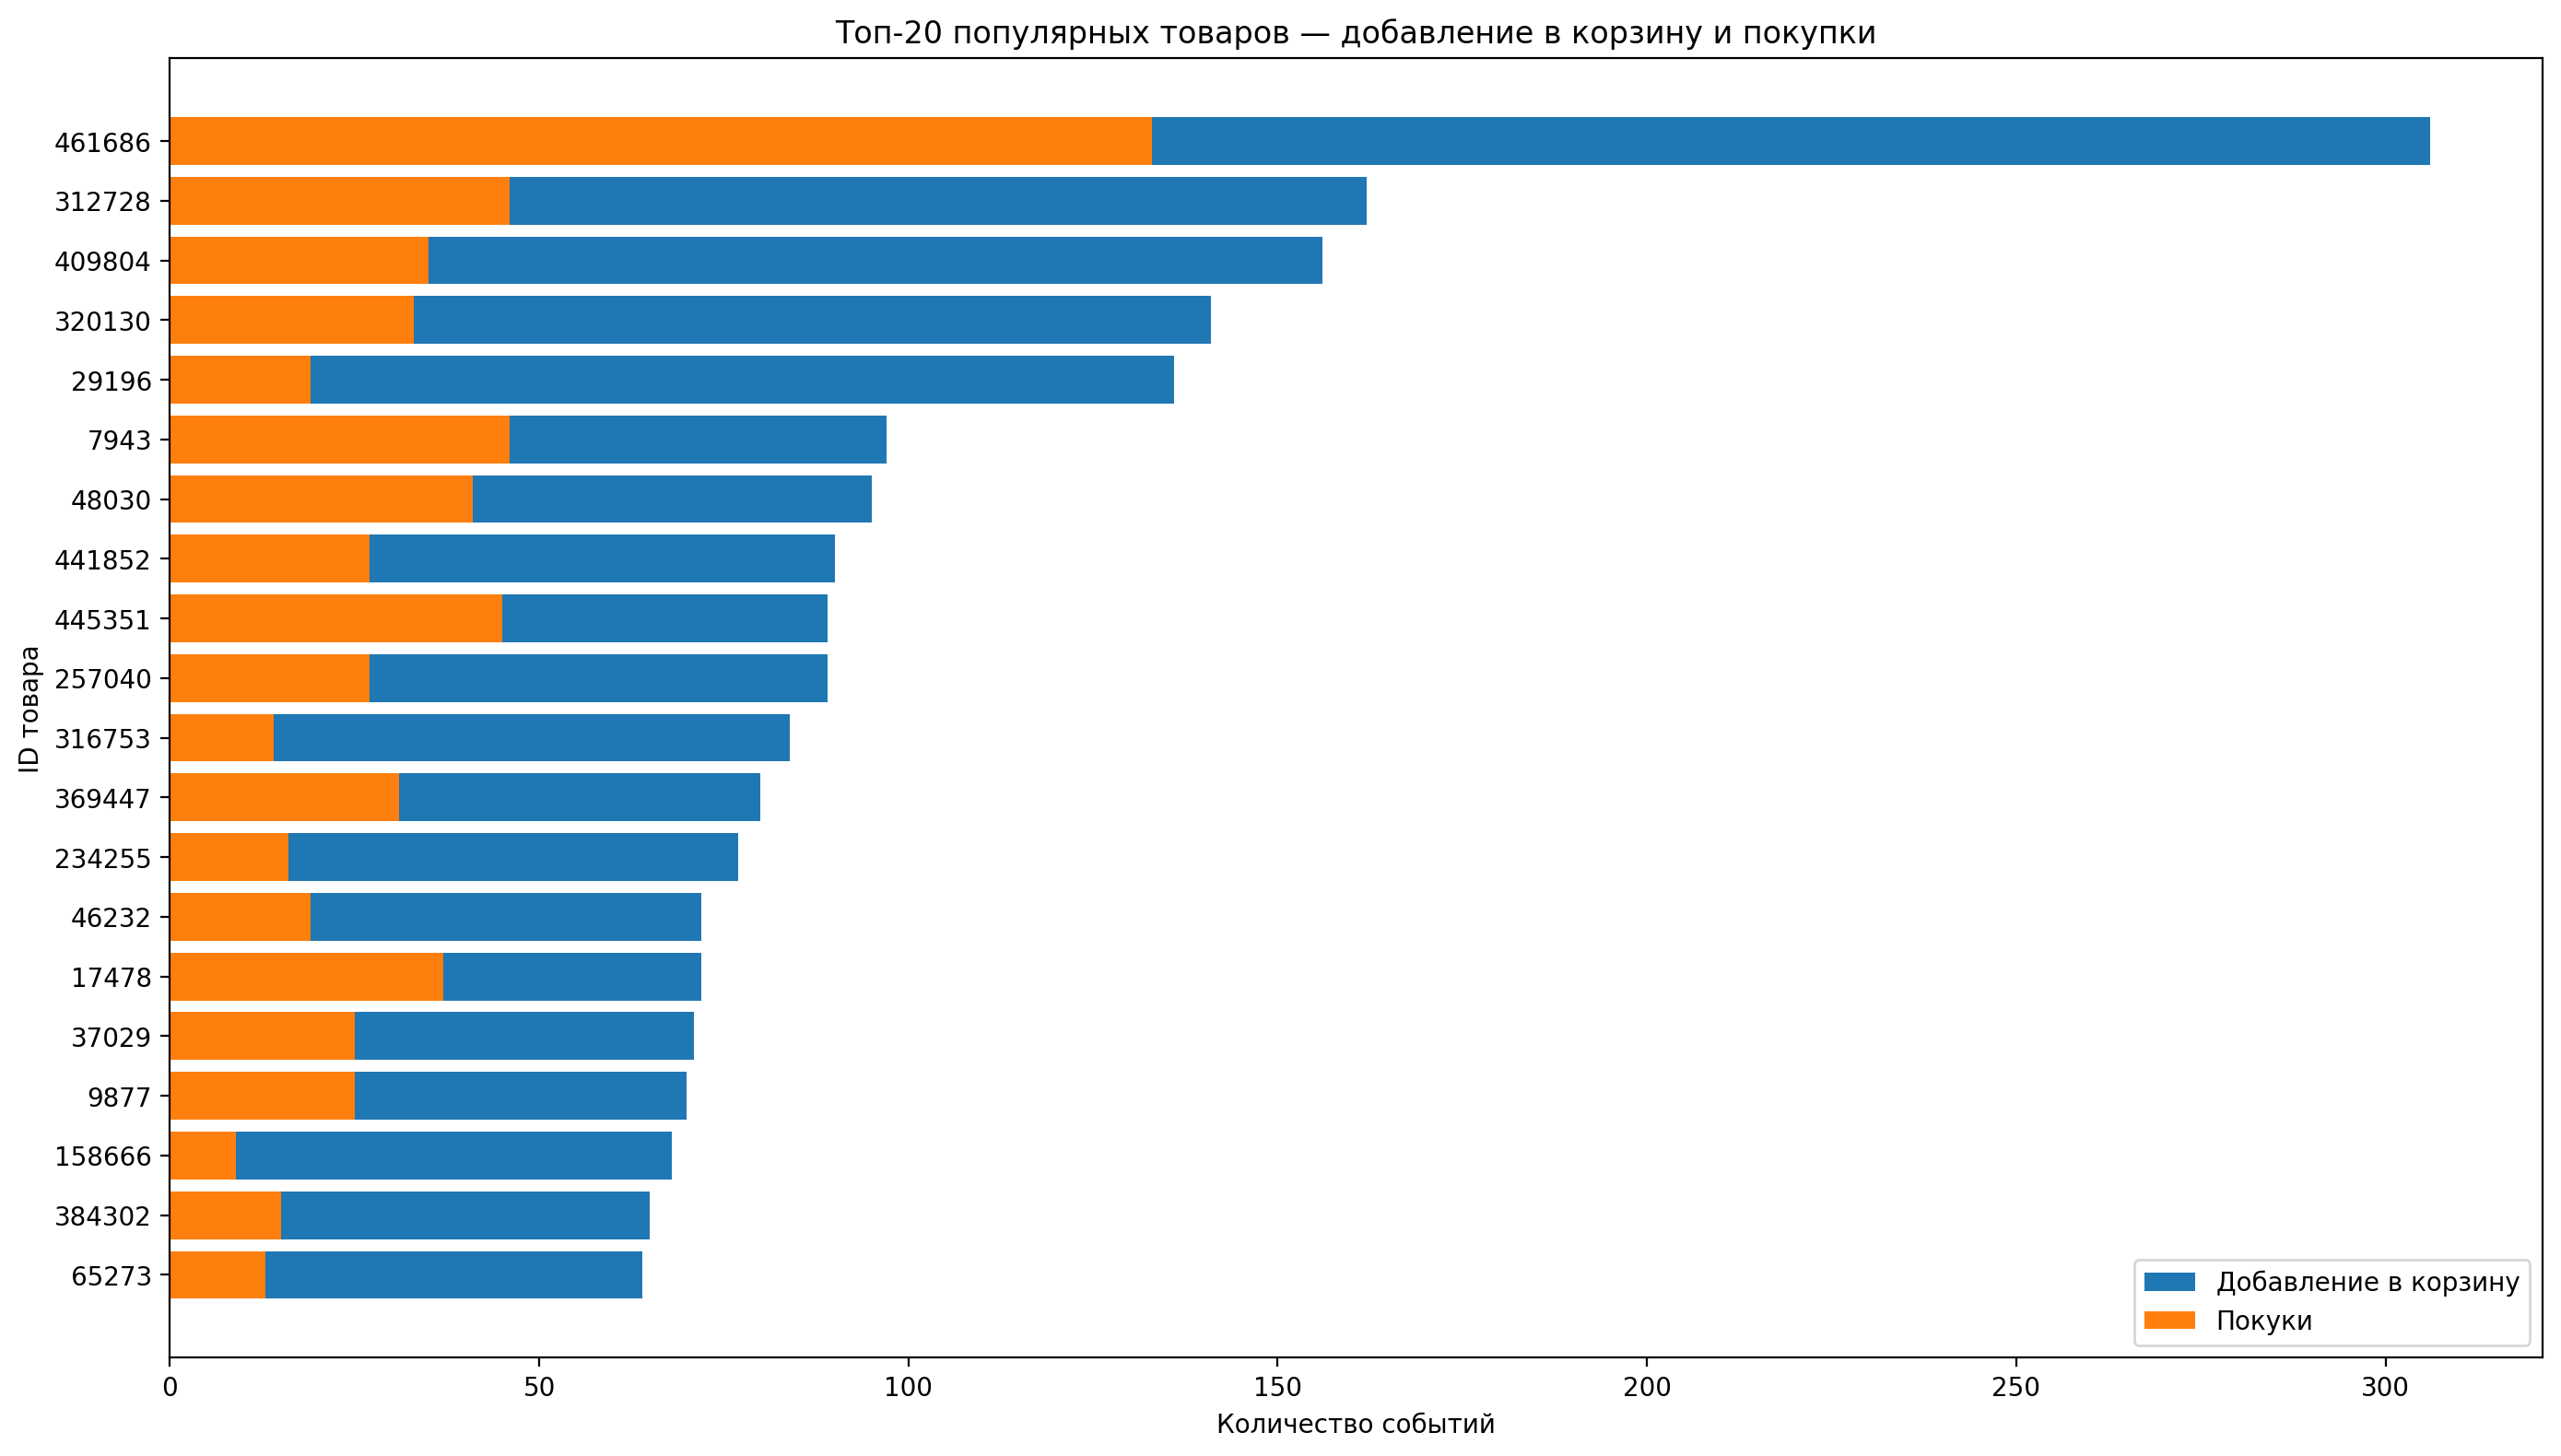

In [155]:
# --- Строим stacked bar chart ---
plt.figure(figsize=(14,8))
plt.barh(top_items_stats["itemid"].astype(str), top_items_stats["add_count"], label="Добавление в корзину")
plt.barh(top_items_stats["itemid"].astype(str), top_items_stats["purchase_count"], label="Покуки")

plt.title("Топ-20 популярных товаров — добавление в корзину и покупки")
plt.xlabel("Количество событий")
plt.ylabel("ID товара")
plt.legend()
plt.tight_layout()
plt.savefig('./EDA/top-20_addtocart_vs_by_items.png')
plt.show()

Видим что процент не большой - возможно ждут скидки/промо на товары